In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import folium.plugins as plugins
# import folium
import os
from multiprocessing import Pool, cpu_count
import seaborn as sns
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *
import pyspark.sql.functions as F
import datetime, time
import random
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month

In [3]:
sc.getConf().getAll()

[('spark.sql.catalogImplementation', 'hive'),
 ('spark.driver.port', '33675'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', 'Host-003'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1547000453943'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
# conf = spark.sparkContext._conf.setAll([("spark.memory.fraction", 0.8),('spark.executor.memory', '1G'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','2G')])
# spark.sparkContext.stop()
# spark = SparkSession.builder.config(conf=conf).getOrCreate()


In [5]:
#Cores para serem usadas nos gráficos
colors = [['#0D47A1','#1565C0','#1976D2','#1E88E5','#2196F3'],
          ['#311B92','#512DA8','#673AB7','#9575CD','#B39DDB'],
          ['#1B5E20','#388E3C','#4CAF50','#81C784','#66BB6A'],
          ['#E65100','#EF6C00','#F57C00','#FB8C00','#FF9800'],
          ['#3E2723','#4E342E','#5D4037','#6D4C41','#795548'],
          ['#BF360C','#D84315','#E64A19','#F4511E','#FF5722'],
          ['#880E4F','#AD1457','#C2185B','#D81B60','#E91E63']
         ]

# Leitura das bases

In [6]:
df = spark.read.parquet('../datasets/datasets/acidentes/')

In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- pesid: string (nullable = true)
 |-- data_inversa: timestamp (nullable = true)
 |-- dia_semana: string (nullable = true)
 |-- horario: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- br: string (nullable = true)
 |-- km: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- causa_acidente: string (nullable = true)
 |-- tipo_acidente: string (nullable = true)
 |-- classificacao_acidente: string (nullable = true)
 |-- fase_dia: string (nullable = true)
 |-- sentido_via: string (nullable = true)
 |-- condicao_metereologica: string (nullable = true)
 |-- tipo_pista: string (nullable = true)
 |-- tracado_via: string (nullable = true)
 |-- uso_solo: string (nullable = true)
 |-- id_veiculo: string (nullable = true)
 |-- tipo_veiculo: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- ano_fabricacao_veiculo: string (nullable = true)
 |-- tipo_envolvido: string (nullable = true)
 |-- estado_fisico: str

# Tamanho da base

In [5]:
df.count()

3709170

In [6]:
df.limit(5).toPandas()

id    pesid data_inversa dia_semana   horario  uf   br    km  \
0   26946  2715647   2011-04-16    Sábado   22:20:00  SP  153  59.9   
1  674607  2033386   2011-08-29    Segunda  16:10:00  RJ  101   488   
2  674607  2033390   2011-08-29    Segunda  16:10:00  RJ  101   488   
3  830363  2525787   2011-01-01    Sábado   01:00:00  RJ  116   214   
4  830383  2533410   2011-01-01    Sábado   00:15:00  CE  116  69.6   

               municipio               causa_acidente     ...       \
0  SAO JOSE DO RIO PRETO           Ingestão de álcool     ...        
1         ANGRA DOS REIS             Falta de atenção     ...        
2         ANGRA DOS REIS             Falta de atenção     ...        
3                  PIRAI                       Outras     ...        
4             CHOROZINHO  Desobediência à sinalização     ...        

  feridos_graves mortos latitude longitude regional delegacia uop ano  \
0           2011                                                        
1           2011                                                        
2           2011                                                        
3           2011                                                        
4           2011                                                        

  nacionalidade naturalidade  
0                             
1                             
2                             
3                             
4                             

[5 rows x 38 columns]

# Funcões

In [7]:
df.select(year('data_inversa')).groupBy('year(data_inversa)').count().show()

+------------------+------+
|year(data_inversa)| count|
+------------------+------+
|              2007|269139|
|              2018|135453|
|              2015|269052|
|              2013|405820|
|              2014|368506|
|              2012|396916|
|              2009|337143|
|              2016|216261|
|              2010|395411|
|              2011|412289|
|              2008|298891|
|              2017|204289|
+------------------+------+



In [8]:
Male = ['Masculino','M']
Female = ['Feminino','I']
week = { 'SEGUNDA': 'SEG','TERÇA':'TER','QUARTA':'QUAR','QUINTA':'QUI','SEXTA':'SEX','SÁBADO':'SAB','DOMINGO':'DOM'}
def parse_sexo(instance):
    if instance in Male:
        return 1
    elif instance in Female:
        return 2
    else:
        return 99
    
def parse_marca(instance):
    return instance.split('/')[0]
import re
def parse_modelo(instance):
    try:
        instance =instance.strip()
        value = instance.split('/')[1]
        value = value.split()[0]
        return value
    except:
        return instance
def parse_week(instance):
    value = instance.split('-')[0].upper()
    return value.strip()
parse_week_udf = udf(parse_week,StringType())

def parse_accident(instance):
    if instance:
        if 'GRAVE' in instance.upper():
            return 'Lesão_Grave'
        elif 'LEVE' in instance.upper():
            return 'Lesão_Leve'
        else:
            return 'Óbito'
    else:
        return None
parse_accident_udf = udf(parse_accident,StringType())

def double_space(instance):
    try:
        if not instance is None:
            return instance.strip()
    except:
        return None
    return none
double_space_udf = udf(double_space,StringType())

# Agrupameto

##  Acidente por pessoa

In [9]:
df.groupBy('pesid').count().count()

3709025

## Acidente

In [10]:
df.groupBy('id').count().count()

1709911

# Brasil

## Quantidade de pessoas envolvidas em acidentes por ano

In [11]:
df_pd = []
df_pd.append(df.select('data_inversa').groupBy('data_inversa').count().toPandas())

In [13]:
df_pd[0].index = df_pd[0].data_inversa

In [14]:
n_accidents_year = df_pd[0].resample('Y').sum()[['count']]

In [15]:
n_accidents_year

count
data_inversa        
2007-12-31    269139
2008-12-31    298891
2009-12-31    337143
2010-12-31    395411
2011-12-31    412289
2012-12-31    396916
2013-12-31    405820
2014-12-31    368506
2015-12-31    269052
2016-12-31    216261
2017-12-31    204289
2018-12-31    135453

## Quantidade de acidentes por ano

In [16]:
cache = df.dropDuplicates(['id'])

In [17]:
df_pd.append(cache.select('data_inversa').groupBy('data_inversa').count().toPandas())

In [18]:
df_pd[1].index = df_pd[1].data_inversa

In [19]:
n_accidents_year_ = df_pd[1].resample('Y').sum()[['count']]

In [20]:
n_accidents_year_

count
data_inversa        
2007-12-31    128444
2008-12-31    141120
2009-12-31    158647
2010-12-31    183479
2011-12-31    192326
2012-12-31    184563
2013-12-31    186745
2014-12-31    169198
2015-12-31    122158
2016-12-31     96361
2017-12-31     89507
2018-12-31     57363

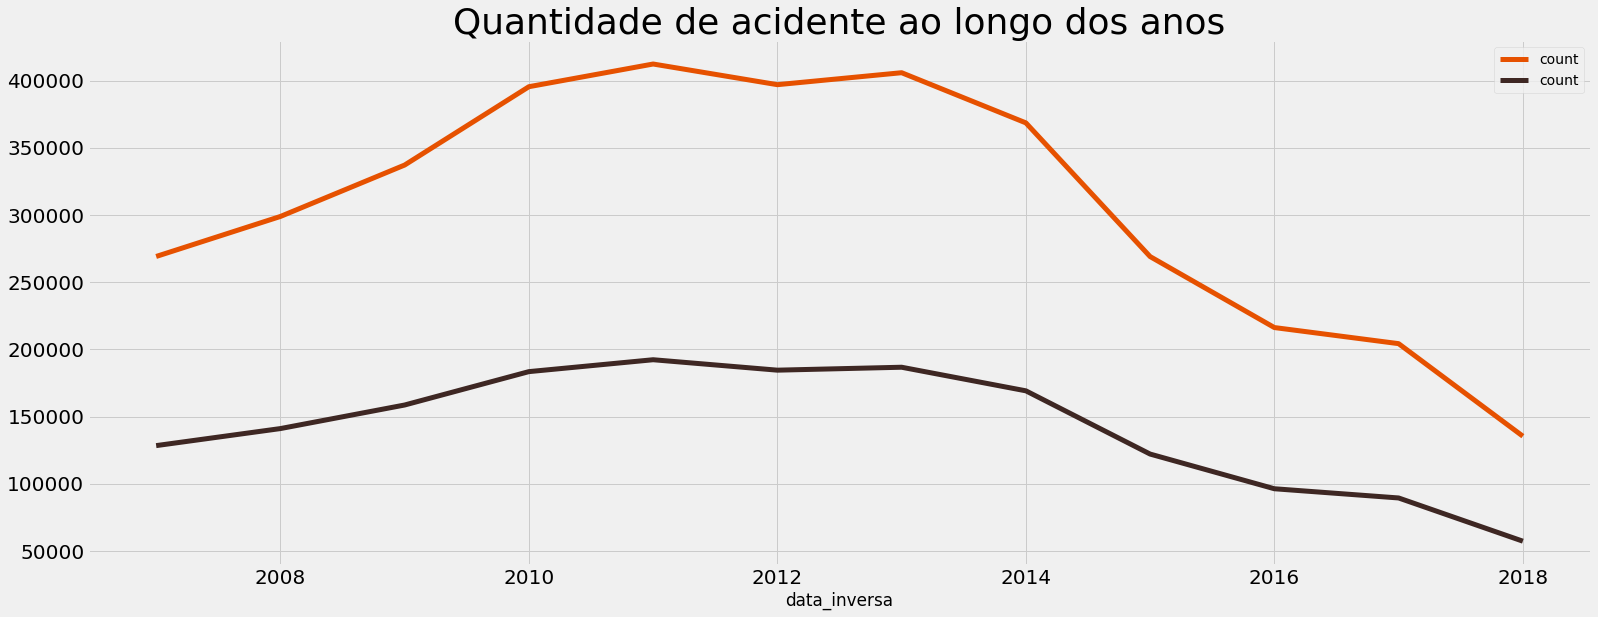

count
data_inversa        
2007-12-31    269139
2008-12-31    298891
2009-12-31    337143
2010-12-31    395411
2011-12-31    412289
2012-12-31    396916
2013-12-31    405820
2014-12-31    368506
2015-12-31    269052
2016-12-31    216261
2017-12-31    204289
2018-12-31    135453

<Figure size 432x288 with 0 Axes>

In [42]:
plt.style.use('fivethirtyeight')
f, ax = plt.subplots(figsize=(24,9))
# ax.set_facecolor("white")
n_accidents_year.plot(ax=ax,color = random.choice(colors),linewidth=5, grid=True,fontsize=20)
n_accidents_year_.plot(ax=ax,color = random.choice(colors),linewidth=5, grid=True,fontsize=20)
plt.title('Quantidade de acidente ao longo dos anos',fontsize=36)
plt.show()
plt.tight_layout()
n_accidents_year

# Estado

In [22]:
df_pd = df.select('uf').groupBy('uf').count().orderBy('count', ascending=False).toPandas()

In [23]:
cache = df.dropDuplicates(['id'])
df_pd_ = cache.select('uf').groupBy('uf').count().orderBy('count', ascending=False).toPandas()

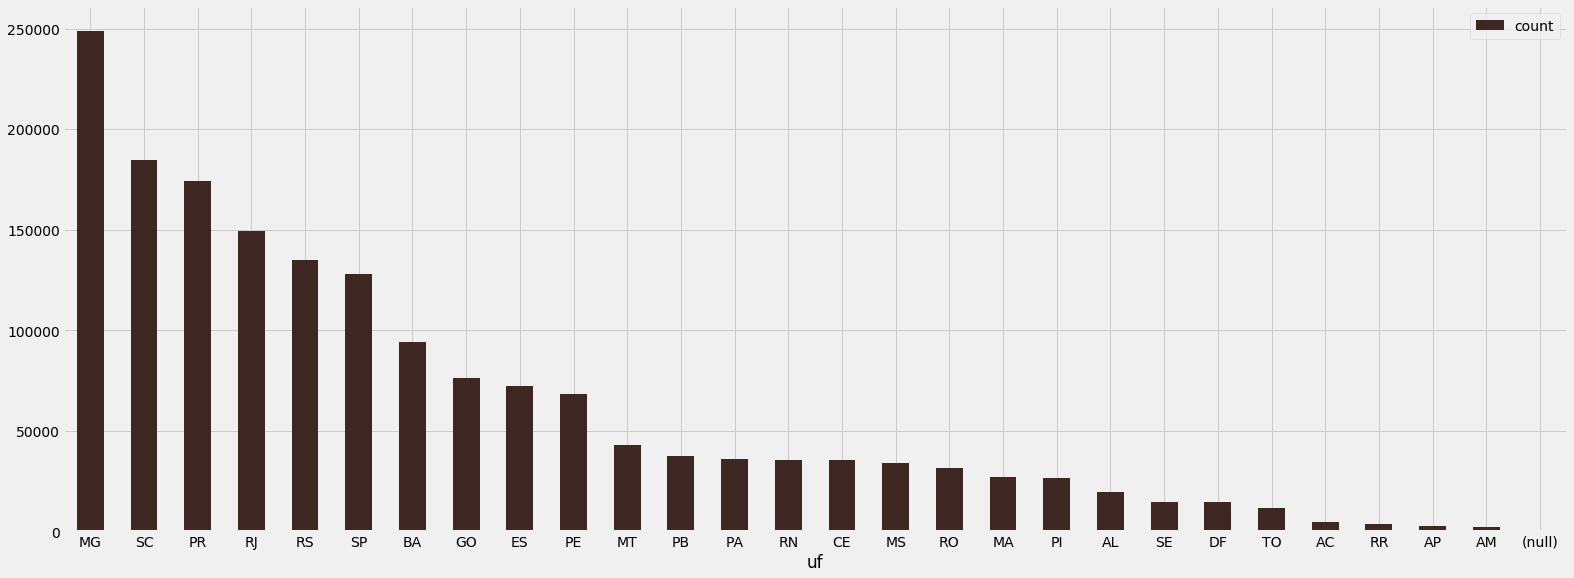

In [24]:
f, ax = plt.subplots(figsize=(24,9))
df_pd_.plot(x='uf',ax=ax,color = random.choice(colors),kind='bar',grid=True,)
# df_pd.plot(x='uf',ax=ax,color = random.choice(colors),kind='bar',grid=True)
plt.xticks(rotation=0)
plt.show()

# SEXO

In [25]:
df_ = df.groupby('sexo').count().toPandas()
df_['sexo'] = df_['sexo'].apply(parse_sexo)

In [26]:
df_ = df_.groupby('sexo',as_index=False).sum()

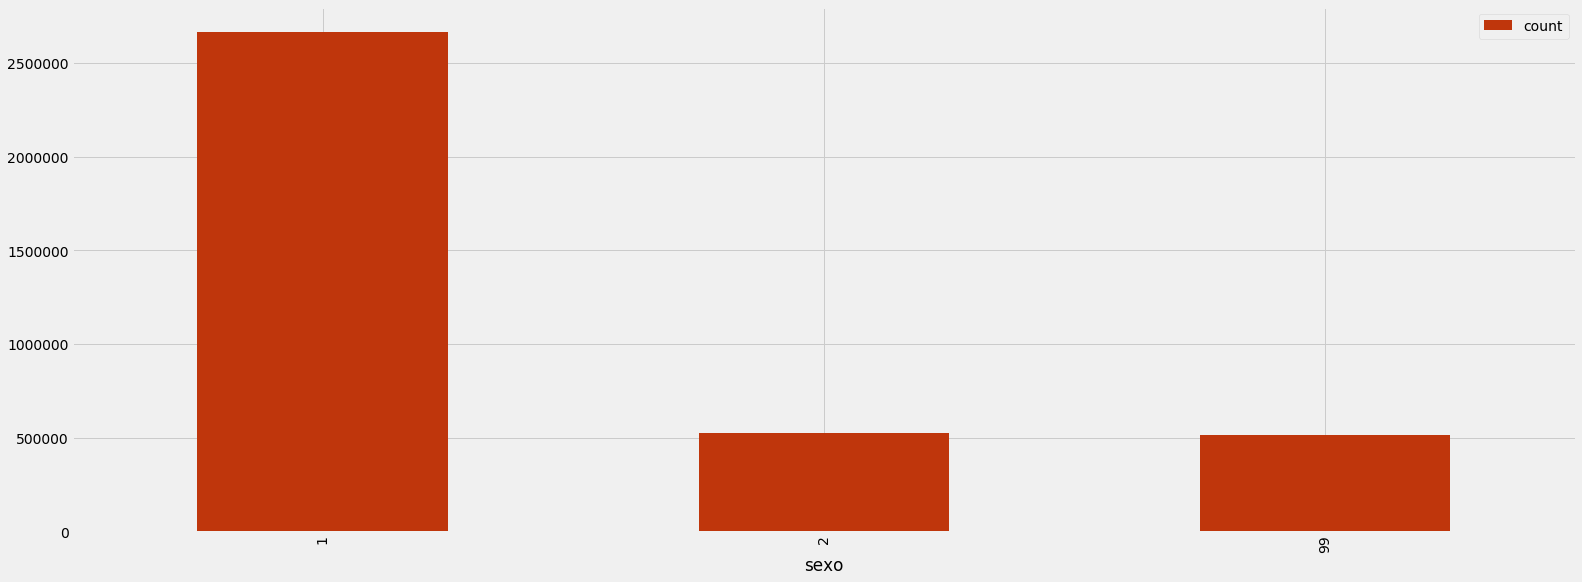

sexo    count
0     1  2667945
1     2   525857
2    99   515368

In [27]:
plt.style.use('fivethirtyeight')
f, ax = plt.subplots(figsize=(24,9))
# ax.set_facecolor("white")
df_.plot(x='sexo',ax=ax,kind='bar',color = random.choice(colors))
plt.show()
df_

# Dia da Semana

In [28]:
cache = df.dropDuplicates(['id'])
cache = cache.withColumn('dia_semana',parse_week_udf(df['dia_semana']))
cache = cache.groupBy('dia_semana').count().toPandas()
cache = cache.sort_values('count', ascending=False)

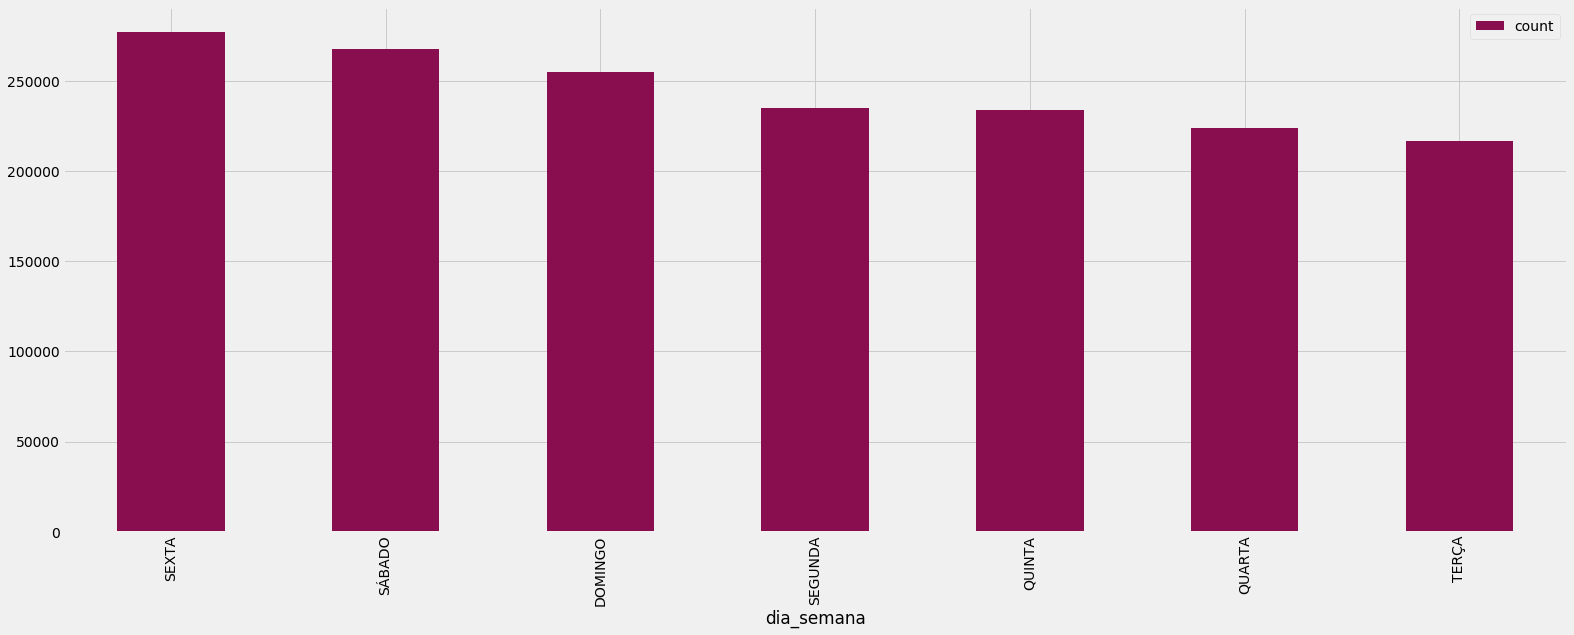

dia_semana   count
2      SEXTA  277292
1     SÁBADO  267626
3    DOMINGO  255021
6    SEGUNDA  235139
0     QUINTA  233820
4     QUARTA  224046
5      TERÇA  216967

In [29]:
plt.style.use('fivethirtyeight')
f, ax = plt.subplots(figsize=(24,9))
# ax.set_facecolor("white")
cache.plot(x='dia_semana',ax=ax,kind='bar',color = random.choice(colors))
plt.show()
cache

# Veiculo

In [30]:
cache = df.withColumn('tipo_veiculo',double_space_udf(df['tipo_veiculo']))

In [31]:
cache = cache.groupBy('tipo_veiculo').count().toPandas()
cache = cache.sort_values('count', ascending=False)[:8]

Py4JJavaError: An error occurred while calling o167.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 42.0 failed 1 times, most recent failure: Lost task 6.0 in stage 42.0 (TID 2947, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 324, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in dump_stream
    for obj in iterator:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 313, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 75, in <lambda>
    return lambda *a: f(*a)
  File "/opt/spark/python/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-8-c3392eca6ebd>", line 46, in double_space
NameError: name 'none' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:297)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3195)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3254)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3253)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3192)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 324, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in dump_stream
    for obj in iterator:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 313, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 75, in <lambda>
    return lambda *a: f(*a)
  File "/opt/spark/python/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-8-c3392eca6ebd>", line 46, in double_space
NameError: name 'none' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
plt.style.use('fivethirtyeight')
f, ax = plt.subplots(figsize=(24,9))
# ax.set_facecolor("white")
cache.plot(x='tipo_veiculo',ax=ax,kind='bar',color = random.choice(colors))
plt.show()
cache

## Quantidade de acidentes por ano - Estado Fisico

In [ ]:
df_pd = df.withColumn('estado_fisico',parse_accident_udf(df['estado_fisico']))

In [ ]:
df_pd.groupby('data_inversa','estado_fisico').count().toPandas()

In [ ]:
df_pd.index = df_pd.data_inversa

In [ ]:
df_pd.drop('data_inversa',axis=1,inplace=True)

In [ ]:
ob = df_pd[df_pd.estado_fisico == 'Óbito'].resample('Y').count()

In [ ]:
styles1 = ['bs-','ro-','y^-']
styles2 = ['r*-','bo-','y^-']
plt.style.use('fivethirtyeight')
f, ax = plt.subplots(figsize=(24,9))
ax.set_facecolor("white")
fte_graph = ob.plot(ax=ax,linewidth=5)
# fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.show()
plt.tight_layout()


In [ ]:
df_pd = df.select('causa_acidente').groupBy('causa_acidente').count().toPandas()
df_pd.groupby('causa_acidente',as_index=False).sum()

In [ ]:
fig = plt.figure(tight_layout=True)
f, ax = plt.subplots(figsize=(24,9))
df_pd.groupby('causa_acidente',as_index=False).sum().plot(x='causa_acidente',ax=ax,color = random.choice(colors),kind='barh',grid=True)
plt.xticks(rotation=0)
fig.align_labels()
plt.show()

In [ ]:
df_ = df.groupby('causa_acidente').count()[['id']]
f, ax = plt.subplots(figsize=(24,9))
df_.plot(ax=ax,color = random.choice(colors),kind='barh',grid=True)
plt.xticks(rotation=0)
plt.show()

## Minas Gerais

### BR

In [32]:
df_pd = df.filter(df.uf == 'MG').select('br').groupBy('br').count().orderBy('count', ascending=False).toPandas()

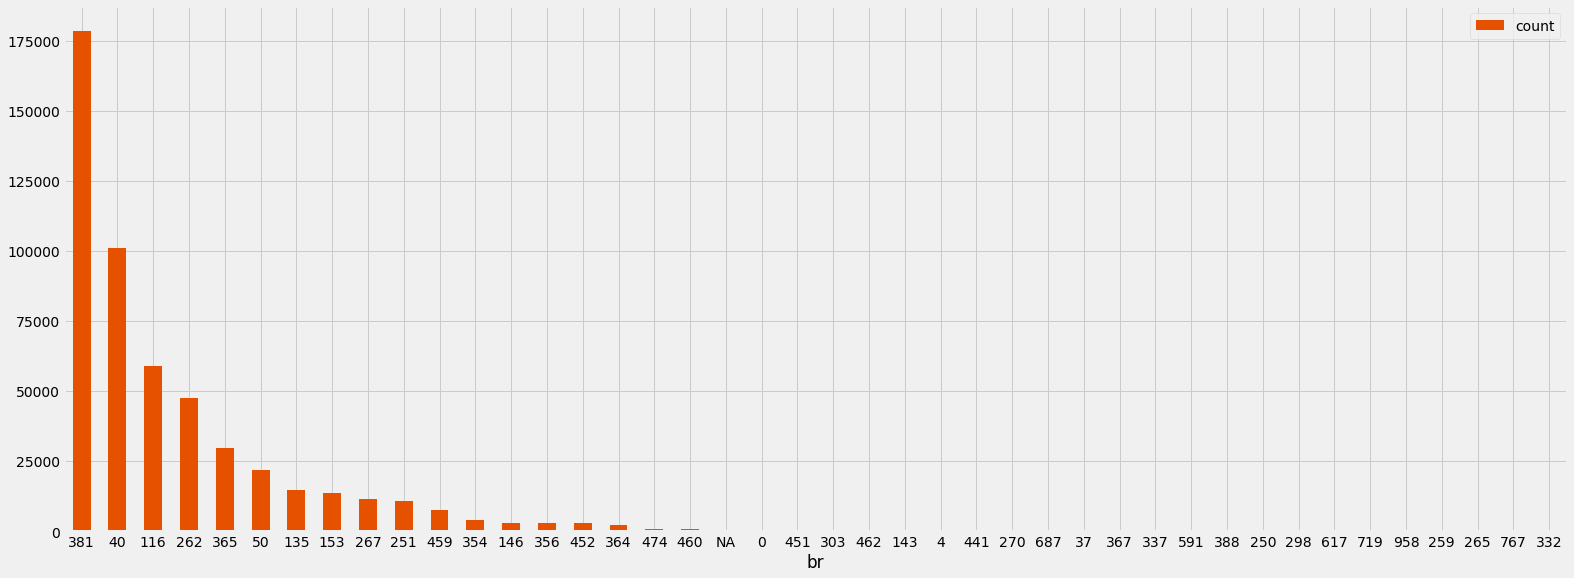

In [33]:
f, ax = plt.subplots(figsize=(24,9))
df_pd.plot(x='br',ax=ax,color = random.choice(colors),kind='bar',grid=True)
plt.xticks(rotation=0)
plt.show()

## Brasil
### BR

In [34]:
df_pd = df.select('br').groupBy('br').count().orderBy('count', ascending=False).toPandas()

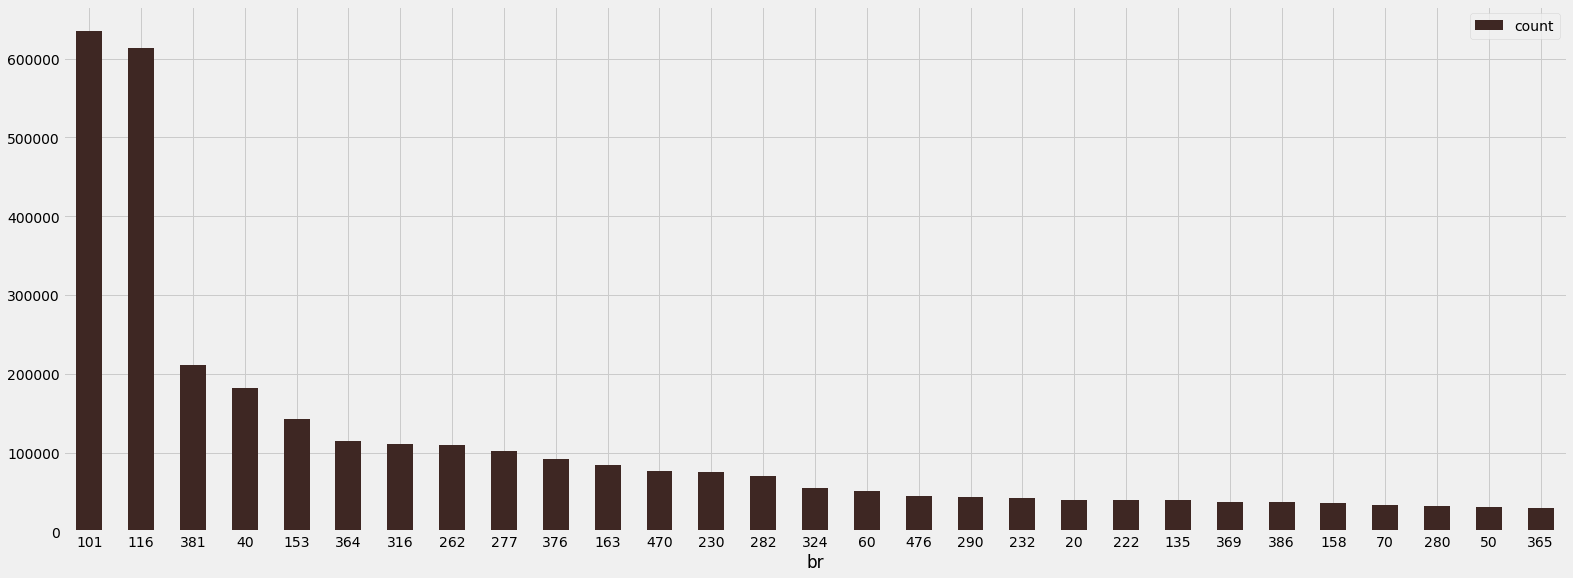

In [35]:
f, ax = plt.subplots(figsize=(24,9))
df_pd[:29].plot(x='br',ax=ax,color = random.choice(colors),kind='bar',grid=True)
plt.xticks(rotation=0)
plt.show()

In [39]:
df_pd = df.filter(df.br == 116).select('km').groupBy('km').count().orderBy('count', ascending=False).toPandas()

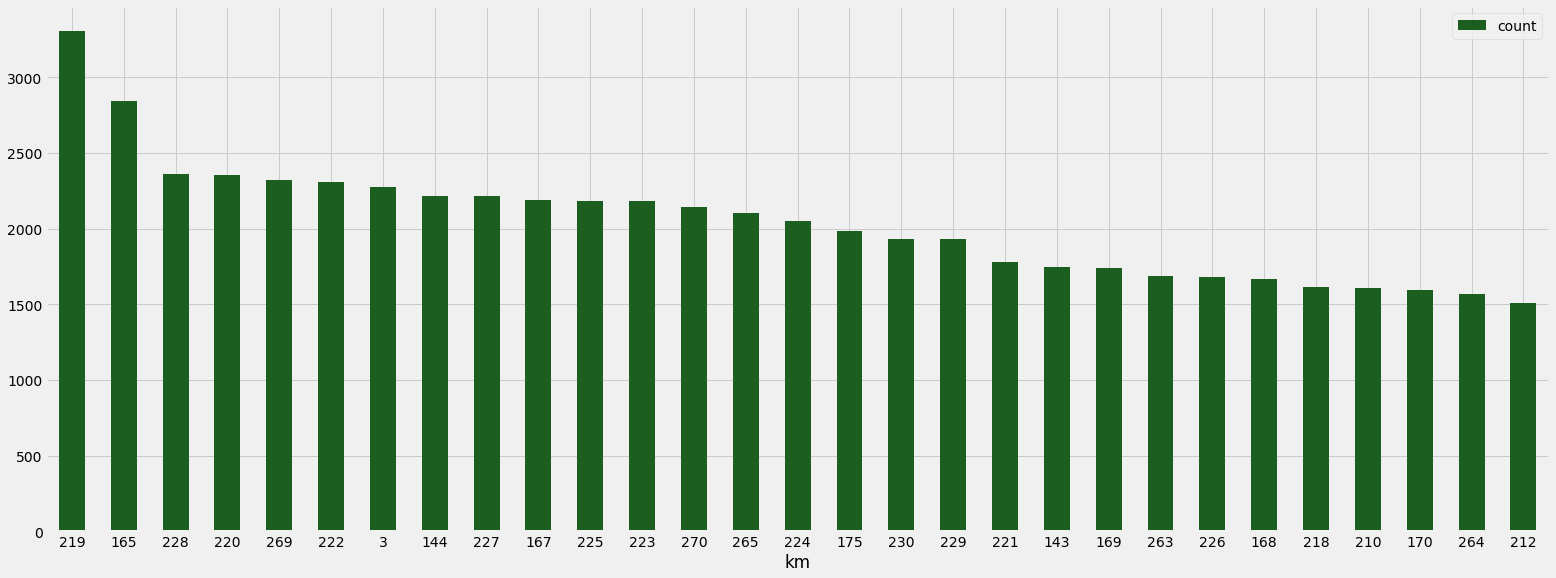

In [40]:
f, ax = plt.subplots(figsize=(24,9))
df_pd[:29].plot(x='km',ax=ax,color = random.choice(colors),kind='bar',grid=True)
plt.xticks(rotation=0)
plt.show()

In [41]:
map_osm = folium.Map(location=[-23.533773,-46.625290], tiles='Mapbox Bright',zoom_start=4)

NameError: name 'folium' is not defined

In [ ]:
map_osm

In [ ]:
path = os.path.join('/home/luancmenezes/Documents/Projetos/prf_analise/dataset_geo/rodovias.json')
path

In [ ]:
df_pd = df.select('br').groupBy('br').count().orderBy('count', ascending=False).toPandas()

In [ ]:
df_pd[:2]

In [ ]:
import json
json.load(open(path))['features']
# keys=[k['id'] for k in json.load(open(path)['features'])]
# missing_keys=set(keys)-set(plot_data['FIPS'])
# dicts=[]
# for k in missing_keys:
#    row={}
#    dicts.append({'FIPS': k, 'Value': 0})
# dicts
# mapdata = country_data
# mapdata = mapdata.append(dicts, ignore_index=True)

In [ ]:
import json

In [ ]:
keys = [k for k in json.load(open(path))['features'] if k['properties']['br'] == '101']
# ['geometry', 'type', 'properties', 'id']

In [ ]:
keys

In [ ]:
[x.keys() for x in keys]

In [43]:
file = os.path.join('/home/luancmenezes/Documents/Projetos/prf_analise/codes/101.json')

In [ ]:
folium.Choropleth(
    geo_data=file
    name='choropleth',
    data=df_pd[:2],
    columns=['br', 'count'],
    key_on='feature.br',
    fill_color='YlOrRd',
    fill_opacity=3,
    line_opacity=3,
    legend_name='Acidentes (%)',
).add_to(map_osm)
folium.LayerControl().add_to(map_osm)
map_osm.save('./br3.html')

In [ ]:
folium.Choropleth?

## causas de morte por sexo

In [ ]:
df[df['sexo'] == 'Masculino']